# Map 5 - Folds and unconformity
This map is from Bennison et al. (2011). It contains folds and an unconformity.

In [1]:
# Import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

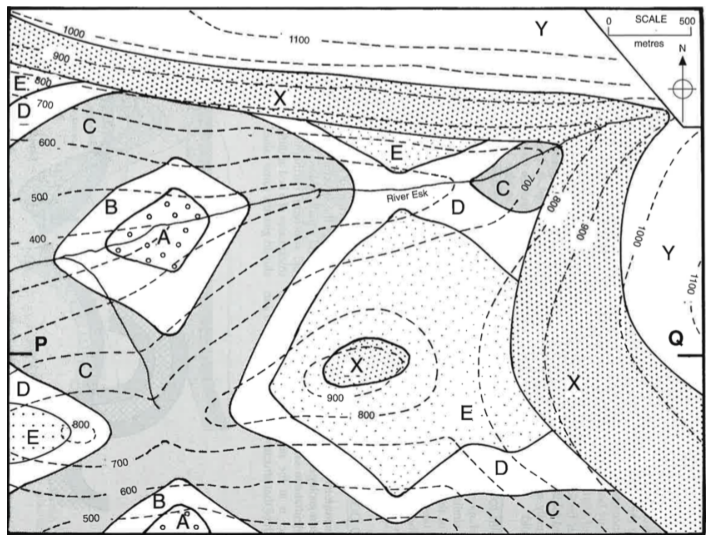

In [2]:
# Display map
img = mpimg.imread('map5.png')
plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.tight_layout()

In [3]:
# Import other required libraries
import geopandas as gpd
import rasterio
import gemgis as gg
import os

In [4]:
# Get current directory
current_directory = os.getcwd()

In [5]:
# Read the topographic contours
topo = gpd.read_file(filename = current_directory+"/contours/contours.shp")
topo.head()

,X,Y,Z,geometry
0,29.51,1804.96,400,POINT (29.509 1804.956)
1,94.51,1811.87,400,POINT (94.506 1811.871)
2,152.48,1821.77,400,POINT (152.481 1821.765)
3,238.68,1833.15,400,POINT (238.682 1833.148)
4,323.14,1844.45,400,POINT (323.137 1844.449)


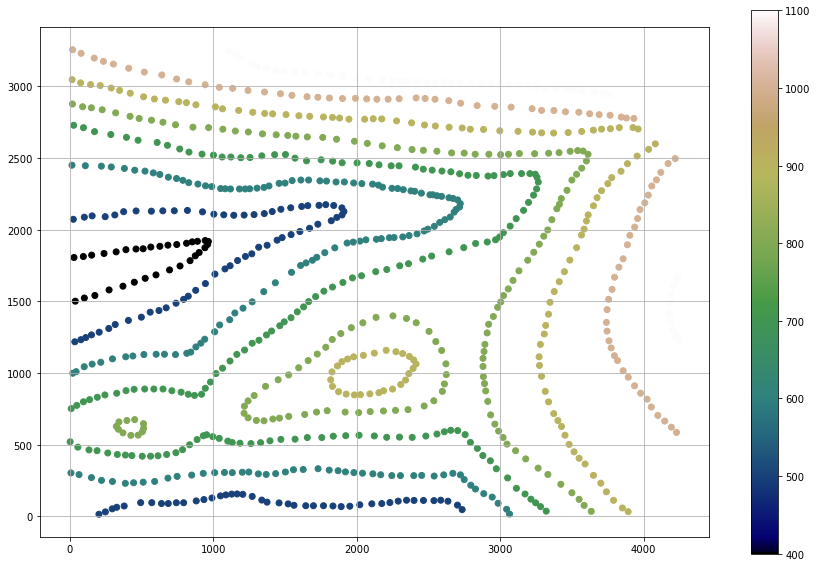

In [6]:
# Plot the contours
fix, ax = plt.subplots(1, figsize=(15, 10))
topo.plot(ax=ax,aspect='equal',column='Z', cmap='gist_earth', legend=True)
plt.grid()

In [7]:
# Interpolate contour lines to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value='Z',method='rbf',res=5)

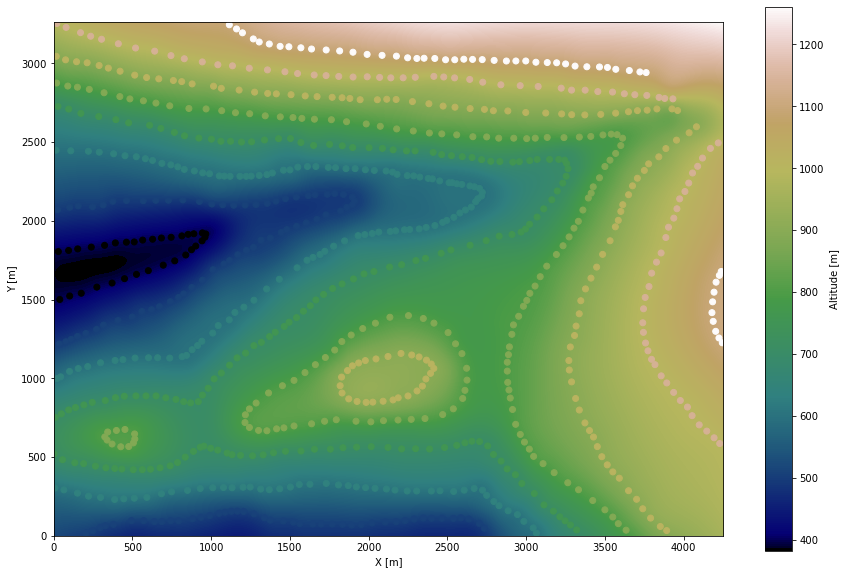

In [8]:
# Plot the DEM
fix, ax = plt.subplots(1, figsize=(15, 10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0, 4252, 0, 3265], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]');

In [9]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path='dem_map5.tif', 
                       extent=[0, 4252, 0, 3265], crs='EPSG:4326', overwrite_file=True)

Raster successfully saved


In [10]:
# Open the DEM from tif file
topo_raster = rasterio.open('dem_map5.tif')

In [11]:
# Read the contacts. These are the bases of the units
contacts = gpd.read_file(current_directory+'/contacts/contacts.shp')
contacts.head()

,X,Y,formation,geometry
0,557.85,2797.43,X,POINT (557.847 2797.426)
1,2712.66,2462.98,X,POINT (2712.664 2462.978)
2,3098.05,1454.49,X,POINT (3098.050 1454.495)
3,2207.05,937.43,X,POINT (2207.055 937.432)
4,2151.63,1210.60,X,POINT (2151.627 1210.600)


In [12]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z

,X,Y,formation,geometry,Z
0,557.85,2797.43,X,POINT (557.847 2797.426),818.22
1,2712.66,2462.98,X,POINT (2712.664 2462.978),746.89
2,3098.05,1454.49,X,POINT (3098.050 1454.495),819.33
3,2207.05,937.43,X,POINT (2207.055 937.432),910.74
4,2151.63,1210.60,X,POINT (2151.627 1210.600),876.80
...,...,...,...,...,...
56,782.23,1998.48,B,POINT (782.226 1998.485),428.69
57,1150.98,1799.88,B,POINT (1150.981 1799.877),489.15
58,728.78,1711.24,B,POINT (728.784 1711.241),405.37
59,1146.77,2069.68,B,POINT (1146.768 2069.679),483.03


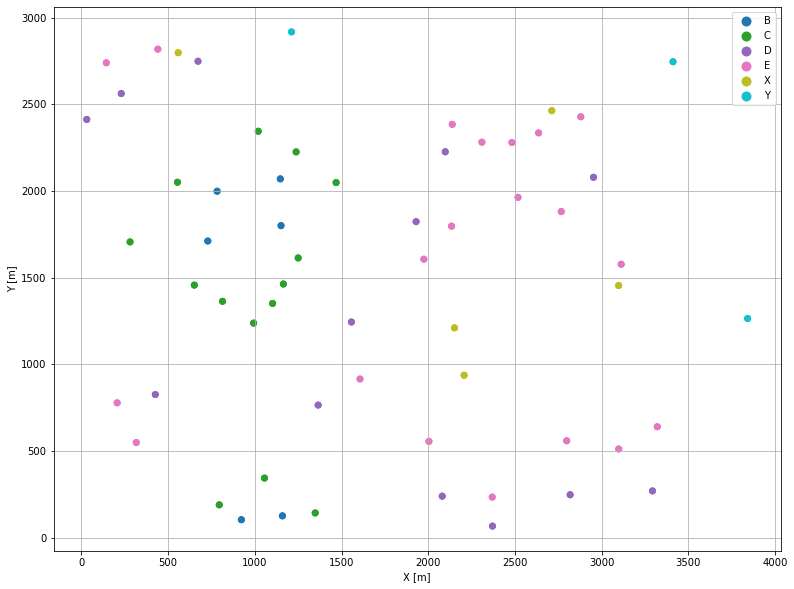

In [13]:
# Plot the points on the contacts
fig, ax = plt.subplots(1, figsize=(15, 10))
contacts.plot(ax=ax, column='formation', legend=True, aspect='equal')
contacts_with_Z.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]');

In [14]:
# Read the strike lines 
# In comparison to maps 1-4, this is a more complex structure, so we need more strike lines
gdf = gpd.read_file(current_directory+'/strike_lines/strike_lines.shp')
gdf

,X,Y,Z,formation,id,geometry
0,3722.82,2697.02,900,X,1,POINT (3722.819 2697.020)
1,4033.66,2567.36,900,X,1,POINT (4033.660 2567.362)
2,3757.64,1529.48,1000,X,2,POINT (3757.645 1529.483)
3,3.25,3239.03,1000,X,2,POINT (3.250 3239.031)
4,2766.61,532.12,700,E1,3,POINT (2766.607 532.117)
5,2756.58,1878.98,700,E1,3,POINT (2756.577 1878.985)
6,3048.86,513.62,800,E1,4,POINT (3048.861 513.615)
7,3067.54,1610.73,800,E1,4,POINT (3067.538 1610.734)
8,2004.38,558.23,700,E2,5,POINT (2004.382 558.229)
9,2025.91,1676.26,700,E2,5,POINT (2025.907 1676.256)


In [15]:
# Convert the points into strike lines
linestring_gdf_X = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'X'])
linestring_gdf_E1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'E1'])
linestring_gdf_E2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'E2'])
linestring_gdf_C = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'C'])
linestring_gdf_D1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'D1'])
linestring_gdf_D2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'D2'])

In [16]:
# Check that the strike lines are valid
linestring_gdf_X.is_valid

0    True
1    True
dtype: bool

In [17]:
linestring_gdf_E1.is_valid

0    True
1    True
dtype: bool

In [18]:
linestring_gdf_E2.is_valid

0    True
1    True
dtype: bool

In [19]:
linestring_gdf_C.is_valid

0    True
1    True
dtype: bool

In [20]:
linestring_gdf_D1.is_valid

0    True
1    True
dtype: bool

In [21]:
linestring_gdf_D2.is_valid

0    True
1    True
dtype: bool

In [22]:
# Calculate orientations
orientations_X = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_X)
orientations_X

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,5.45,24.47,950.00,POINT (2879.343 2508.224),1.00,2879.34,2508.22,X


In [23]:
orientations_E1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_E1)
orientations_E1

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,19.49,270.14,750.00,POINT (2909.896 1133.863),1.00,2909.90,1133.86,E1


In [24]:
orientations_E2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_E2)
orientations_E2

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,20.47,90.57,750.00,POINT (1871.801 1026.256),1.00,1871.80,1026.26,E2


In [25]:
orientations_C = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_C)
orientations_C

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,19.26,268.42,450.00,POINT (514.311 1762.887),1.00,514.31,1762.89,C


In [26]:
orientations_D1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_D1)
orientations_D1

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,20.73,90.82,650.00,POINT (1870.492 2068.261),1.00,1870.49,2068.26,D1


In [27]:
orientations_D2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_D2)
orientations_D2

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,18.84,270.81,650.00,POINT (221.094 1748.368),1.00,221.09,1748.37,D2


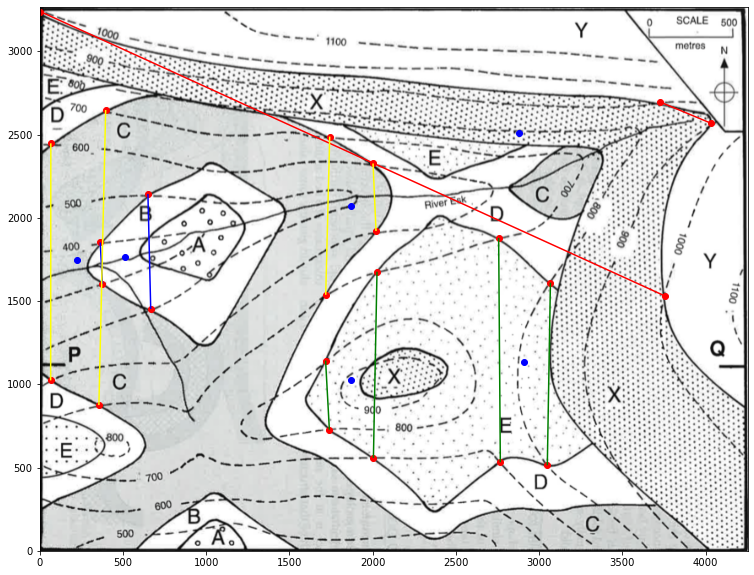

In [28]:
# Plot all this information on the map, so we can better understand this structure
fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.imshow(img, extent=[0, 4252, 0, 3265], cmap='gray')
# plot points
gdf.plot(ax=ax, aspect='equal', color='red')
# plot strike lines
# base of X
linestring_gdf_X.plot(ax=ax, aspect='equal', color='red')
orientations_X.plot(ax=ax, aspect='equal', color='blue')
# eastern fold, eastern flank, base of E
linestring_gdf_E1.plot(ax=ax, aspect='equal', color='green')
orientations_E1.plot(ax=ax, aspect='equal', color='blue')
# eastern fold, western flank, base of E
linestring_gdf_E2.plot(ax=ax, aspect='equal', color='green')
orientations_E2.plot(ax=ax, aspect='equal', color='blue')
# western fold, western flank, base of C
linestring_gdf_C.plot(ax=ax, aspect='equal', color='blue')
orientations_C.plot(ax=ax, aspect='equal', color='blue')
# western fold, eastern flank, base of D
linestring_gdf_D1.plot(ax=ax, aspect='equal', color='yellow')
orientations_D1.plot(ax=ax, aspect='equal', color='blue')
# western fold, western flank, base of D
linestring_gdf_D2.plot(ax=ax, aspect='equal', color='yellow')
orientations_D2.plot(ax=ax, aspect='equal', color='blue');

So, from the orientations derived from the strike lines, units A (oldest) to E are folded into an anticline (west) syncline (east) pair, trending N-S. A outcrops at the core of the anticline, while E outcrops at the core of the syncline. The dips of the folds limbs are 19-20 degrees. The base of X is an unconformity dipping 5 degrees to the NE. Units X and Y lie unconformably over folded units A-E. 

In [29]:
# Merge orientations
import pandas as pd
orientations = pd.concat([orientations_X, orientations_E1,orientations_E2,orientations_C,orientations_D1,orientations_D2]).reset_index()
orientations

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,5.45,24.47,950.00,POINT (2879.343 2508.224),1.00,2879.34,2508.22,X
1,0,19.49,270.14,750.00,POINT (2909.896 1133.863),1.00,2909.90,1133.86,E1
2,0,20.47,90.57,750.00,POINT (1871.801 1026.256),1.00,1871.80,1026.26,E2
3,0,19.26,268.42,450.00,POINT (514.311 1762.887),1.00,514.31,1762.89,C
4,0,20.73,90.82,650.00,POINT (1870.492 2068.261),1.00,1870.49,2068.26,D1
5,0,18.84,270.81,650.00,POINT (221.094 1748.368),1.00,221.09,1748.37,D2


In [30]:
# Rename the orientations correctly
orientations['formation'] = ['X', 'E', 'E', 'C', 'D','D']
orientations

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,5.45,24.47,950.00,POINT (2879.343 2508.224),1.00,2879.34,2508.22,X
1,0,19.49,270.14,750.00,POINT (2909.896 1133.863),1.00,2909.90,1133.86,E
2,0,20.47,90.57,750.00,POINT (1871.801 1026.256),1.00,1871.80,1026.26,E
3,0,19.26,268.42,450.00,POINT (514.311 1762.887),1.00,514.31,1762.89,C
4,0,20.73,90.82,650.00,POINT (1870.492 2068.261),1.00,1870.49,2068.26,D
5,0,18.84,270.81,650.00,POINT (221.094 1748.368),1.00,221.09,1748.37,D


# Construction of the model in GemPy

In [31]:
# Import Gempy
import gempy as gp

In [32]:
# Create a geomodel object called model5
geo_model = gp.create_model('model5')

In [33]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 4252, 0, 3265, 0, 1000], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [34]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,X,Default series,1,#015482,1
1,Y,Default series,2,#9f0052,2
2,E,Default series,3,#ffbe00,3
3,D,Default series,4,#728f02,4
4,C,Default series,5,#443988,5
5,B,Default series,6,#ff3f20,6


In [35]:
# The base of the lowermost unit A does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces('A')

# The units are divided into 2 series
# Strata1 = units above the unconformity
# Strata2 = units below the unconformity
gp.map_stack_to_surfaces(geo_model, {'Strata1': ('Y', 'X'),'Strata2': ('E','D', 'C','B','A'),},
                         remove_unused_series=True)

,surface,series,order_surfaces,color,id
0,X,Strata1,1,#015482,1
1,Y,Strata1,2,#9f0052,2
2,E,Strata2,1,#ffbe00,3
3,D,Strata2,2,#728f02,4
4,C,Strata2,3,#443988,5
5,B,Strata2,4,#ff3f20,6
6,A,Strata2,5,#5DA629,7


In [36]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,X,Strata1,1,#015482,1,5,1
1,Y,Strata1,2,#9f0052,2,3,0
2,E,Strata2,1,#ffbe00,3,20,2
3,D,Strata2,2,#728f02,4,13,2
4,C,Strata2,3,#443988,5,14,1
5,B,Strata2,4,#ff3f20,6,6,0
6,A,Strata2,5,#5DA629,7,0,0


In [37]:
# Set the topography of the model
geo_model.set_topography(source='gdal',filepath='dem_map5.tif');

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [38]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
from pyvistaqt import BackgroundPlotter
gp.plot_3d(geo_model, plotter_type='background',show_topography=True);

In [39]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True, 
                    theano_optimizer='fast_compile');

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             5453.41
$C_o$           708088.79
drift equations    [3, 3]


In [40]:
# Ignore warnings from np
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

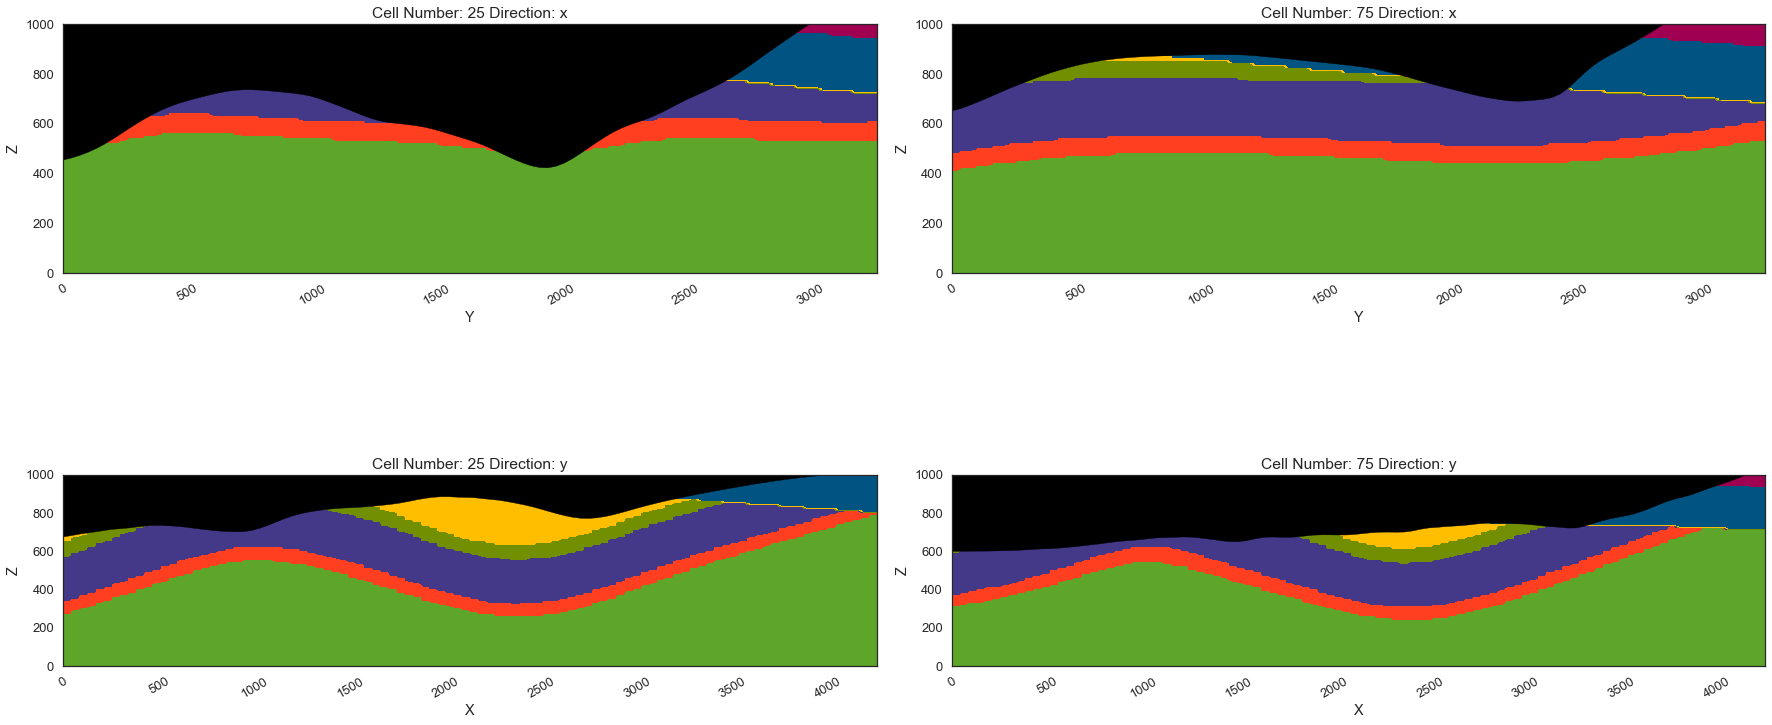

In [41]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [42]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type='background', show_topography=True, show_lith=False);